# NBA Playoff Prediction - Neural Network

This notebook implements neural networks with L2 regularization for predicting NBA playoff qualification.


In [95]:
import os

DATA_PATH = "./data/processed"
MODEL_PATH = "./models/neural_network"
RESULTS_PATH = "./results/neural_network"

os.makedirs(MODEL_PATH, exist_ok=True)
os.makedirs(RESULTS_PATH, exist_ok=True)

In [96]:
import numpy as np
import json
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

X_train = np.load(f"{DATA_PATH}/X_train_scaled.npy")
X_val = np.load(f"{DATA_PATH}/X_val_scaled.npy")
X_test = np.load(f"{DATA_PATH}/X_test_scaled.npy")
y_train = np.load(f"{DATA_PATH}/y_train.npy")
y_val = np.load(f"{DATA_PATH}/y_val.npy")
y_test = np.load(f"{DATA_PATH}/y_test.npy")

with open(f"{DATA_PATH}/feature_names.json", 'r') as f:
    feature_cols = json.load(f)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"Features: {len(feature_cols)}")

Train: (446, 28), Val: (120, 28), Test: (120, 28)
Features: 28


## Model Configuration


In [97]:
class_weight = {
    0: len(y_train) / (2 * (len(y_train) - y_train.sum())),
    1: len(y_train) / (2 * y_train.sum())
}
print(f"Class weights: {class_weight}")

Class weights: {0: 1.0825242718446602, 1: 0.9291666666666667}


In [98]:
print(f"Using original features: {X_train.shape[1]} features")

layer_architectures = [
    {'name': '2-Layer', 'layers': [128, 64]},
    {'name': '2-Layer', 'layers': [64, 32]},
    {'name': '3-Layer', 'layers': [256, 128, 64]},
    {'name': '5-Layer', 'layers': [512, 256, 128, 64, 32]},
]

regularization_configs = [
    {'name': 'L2-0', 'l2': 0},
    {'name': 'L2-0.01', 'l2': 0.01},
    {'name': 'L2-0.001', 'l2': 0.001},
    {'name': 'L2-0.1', 'l2': 0.1},
    {'name': 'L2-1', 'l2': 1},
    {'name': 'L2-10', 'l2': 10},
]

print(f"{len(layer_architectures)} layer architectures")
print(f"{len(regularization_configs)} regularization configurations")
print(f"Total models: {len(layer_architectures) * len(regularization_configs)}")

Using original features: 28 features
4 layer architectures
6 regularization configurations
Total models: 24


## Train Models with Regularization


In [99]:
def build_model(input_dim, layer_sizes, reg):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
    ])
    
    for units in layer_sizes:
        model.add(layers.Dense(units, activation='relu', kernel_regularizer=reg))
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

all_results = []
model_counter = 0
total_models = len(layer_architectures) * len(regularization_configs)

print("\n" + "=" * 80)
print(f"TRAINING {total_models} MODELS")
print("=" * 80 + "\n")

for arch_config in layer_architectures:
    arch_name = arch_config['name']
    layer_sizes = arch_config['layers']
    
    print(f"{arch_name} Architecture: {layer_sizes}")
    print("-" * 60)
    
    for reg_config in regularization_configs:
        model_counter += 1
        model_name = f"{arch_name}_{reg_config['name']}"
        
        l2_value = reg_config.get('l2', 0.0)
        
        if l2_value > 0:
            reg = l2(l2_value)
        else:
            reg = None
        
        model = build_model(X_train.shape[1], layer_sizes, reg)
        
        early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=0)
        batch_size = max(8, min(32, len(X_train) // 4))
        
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=200,
            batch_size=batch_size,
            class_weight=class_weight,
            callbacks=[early_stop],
            verbose=0
        )
        
        y_test_pred_prob = model.predict(X_test, verbose=0, batch_size=batch_size).flatten()
        y_test_pred = (y_test_pred_prob > 0.5).astype(int)
        
        test_acc = accuracy_score(y_test, y_test_pred)
        test_auc = roc_auc_score(y_test, y_test_pred_prob)
        test_f1 = f1_score(y_test, y_test_pred)
        test_recall = recall_score(y_test, y_test_pred)
        
        results = {
            'model_id': f"{model_counter:02d}",
            'architecture': arch_name,
            'regularization': reg_config['name'],
            'test_acc': test_acc,
            'test_auc': test_auc,
            'test_f1': test_f1,
            'test_recall': test_recall,
        }
        
        all_results.append(results)
        print(f"  {reg_config['name']}: Acc={test_acc:.4f}, AUC={test_auc:.4f}, F1={test_f1:.4f}")
        
        model.save(f"{MODEL_PATH}/{model_name}.keras")
    
    print()

print("Training complete")


TRAINING 24 MODELS

2-Layer Architecture: [128, 64]
------------------------------------------------------------
  L2-0: Acc=0.8750, AUC=0.9813, F1=0.8936
  L2-0: Acc=0.8750, AUC=0.9813, F1=0.8936
  L2-0.01: Acc=0.9083, AUC=0.9805, F1=0.9197
  L2-0.01: Acc=0.9083, AUC=0.9805, F1=0.9197
  L2-0.001: Acc=0.8667, AUC=0.9749, F1=0.8857
  L2-0.001: Acc=0.8667, AUC=0.9749, F1=0.8857
  L2-0.1: Acc=0.8917, AUC=0.9763, F1=0.9051
  L2-0.1: Acc=0.8917, AUC=0.9763, F1=0.9051
  L2-1: Acc=0.8167, AUC=0.9774, F1=0.8514
  L2-1: Acc=0.8167, AUC=0.9774, F1=0.8514
  L2-10: Acc=0.5333, AUC=0.6574, F1=0.6957

2-Layer Architecture: [64, 32]
------------------------------------------------------------
  L2-10: Acc=0.5333, AUC=0.6574, F1=0.6957

2-Layer Architecture: [64, 32]
------------------------------------------------------------
  L2-0: Acc=0.8333, AUC=0.9743, F1=0.8630
  L2-0: Acc=0.8333, AUC=0.9743, F1=0.8630
  L2-0.01: Acc=0.9000, AUC=0.9805, F1=0.9130
  L2-0.01: Acc=0.9000, AUC=0.9805, F1=0.9130
  

In [100]:
results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values('test_auc', ascending=False)
results_df.to_csv(f"{RESULTS_PATH}/model_results.csv", index=False)

print("\nModel Results Summary:")
print(results_df[['architecture', 'test_acc', 'test_auc', 'test_f1']].to_string(index=False))


Model Results Summary:
architecture  test_acc  test_auc  test_f1
     5-Layer  0.883333  0.981864 0.901408
     2-Layer  0.875000  0.981306 0.893617
     3-Layer  0.883333  0.980748 0.901408
     2-Layer  0.908333  0.980469 0.919708
     2-Layer  0.900000  0.980469 0.913043
     3-Layer  0.900000  0.978237 0.913043
     3-Layer  0.875000  0.977679 0.892086
     2-Layer  0.816667  0.977400 0.851351
     2-Layer  0.891667  0.976283 0.905109
     2-Layer  0.900000  0.976283 0.911765
     3-Layer  0.858333  0.976004 0.881119
     2-Layer  0.875000  0.975167 0.893617
     2-Layer  0.866667  0.974888 0.885714
     2-Layer  0.833333  0.974330 0.863014
     5-Layer  0.883333  0.974330 0.898551
     5-Layer  0.883333  0.973772 0.900000
     2-Layer  0.533333  0.933175 0.695652
     2-Layer  0.533333  0.787388 0.695652
     2-Layer  0.533333  0.657366 0.695652
     3-Layer  0.533333  0.500000 0.695652
     3-Layer  0.533333  0.500000 0.695652
     5-Layer  0.533333  0.500000 0.695652
     5-Lay

In [101]:
print("Performance by architecture:")
arch_summary = results_df.groupby('architecture').agg({
    'test_acc': 'mean',
    'test_auc': 'mean',
    'test_f1': 'mean'
}).round(4)
print(arch_summary)

Performance by architecture:
              test_acc  test_auc  test_f1
architecture                             
2-Layer         0.7889    0.9312   0.8437
3-Layer         0.7639    0.8188   0.8298
5-Layer         0.7083    0.7383   0.7978


## Evaluate Models


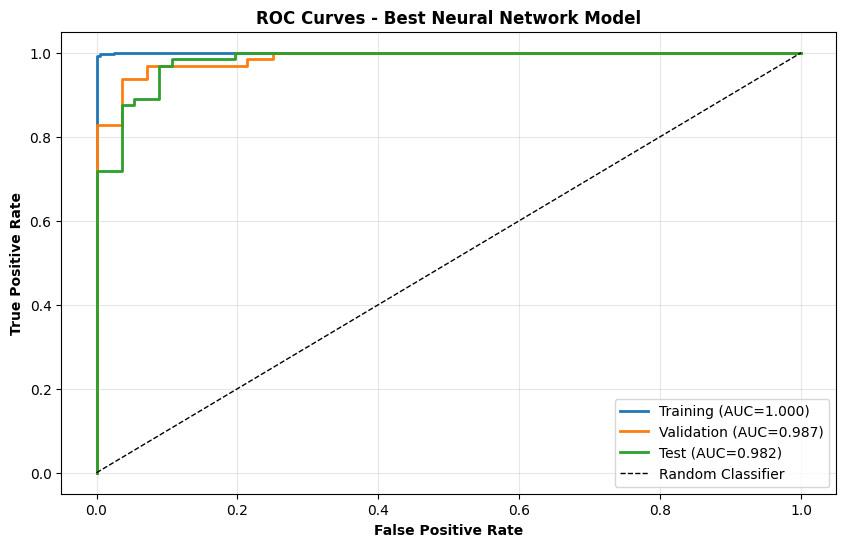

In [104]:
# ROC Curves for Train, Val, Test sets
from sklearn.metrics import roc_curve

plt.figure(figsize=(10, 6))

for name, X_data, y_data in [
    ("Training", X_train, y_train),
    ("Validation", X_val, y_val),
    ("Test", X_test, y_test)
]:
    y_prob = best_model.predict(X_data, verbose=0, batch_size=batch_size).flatten()
    fpr, tpr, _ = roc_curve(y_data, y_prob)
    auc = roc_auc_score(y_data, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})", linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate', fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
plt.title('ROC Curves - Best Neural Network Model', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(f"{RESULTS_PATH}/roc_curves.png", dpi=300, bbox_inches='tight')
plt.show()

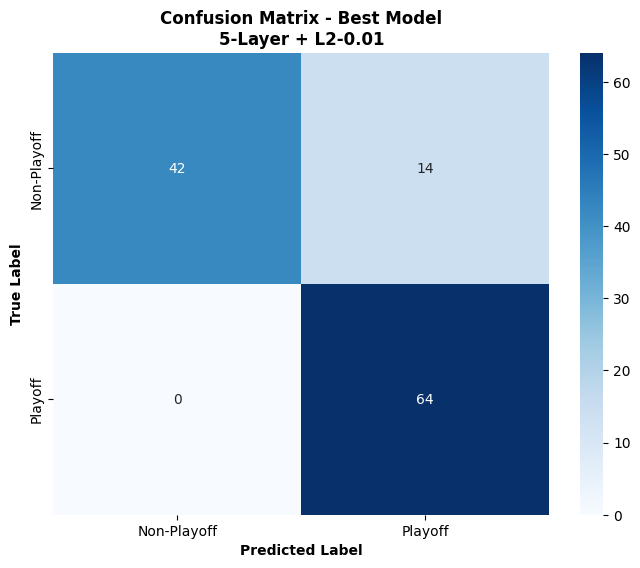

In [105]:
# Confusion Matrix Heatmap for Best Model
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True, 
            xticklabels=['Non-Playoff', 'Playoff'],
            yticklabels=['Non-Playoff', 'Playoff'])
plt.xlabel('Predicted Label', fontweight='bold')
plt.ylabel('True Label', fontweight='bold')
plt.title(f'Confusion Matrix - Best Model\n{best_model_row["architecture"]} + {best_model_row["regularization"]}', 
          fontweight='bold')
plt.savefig(f"{RESULTS_PATH}/confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

## Hyperparameter Tuning


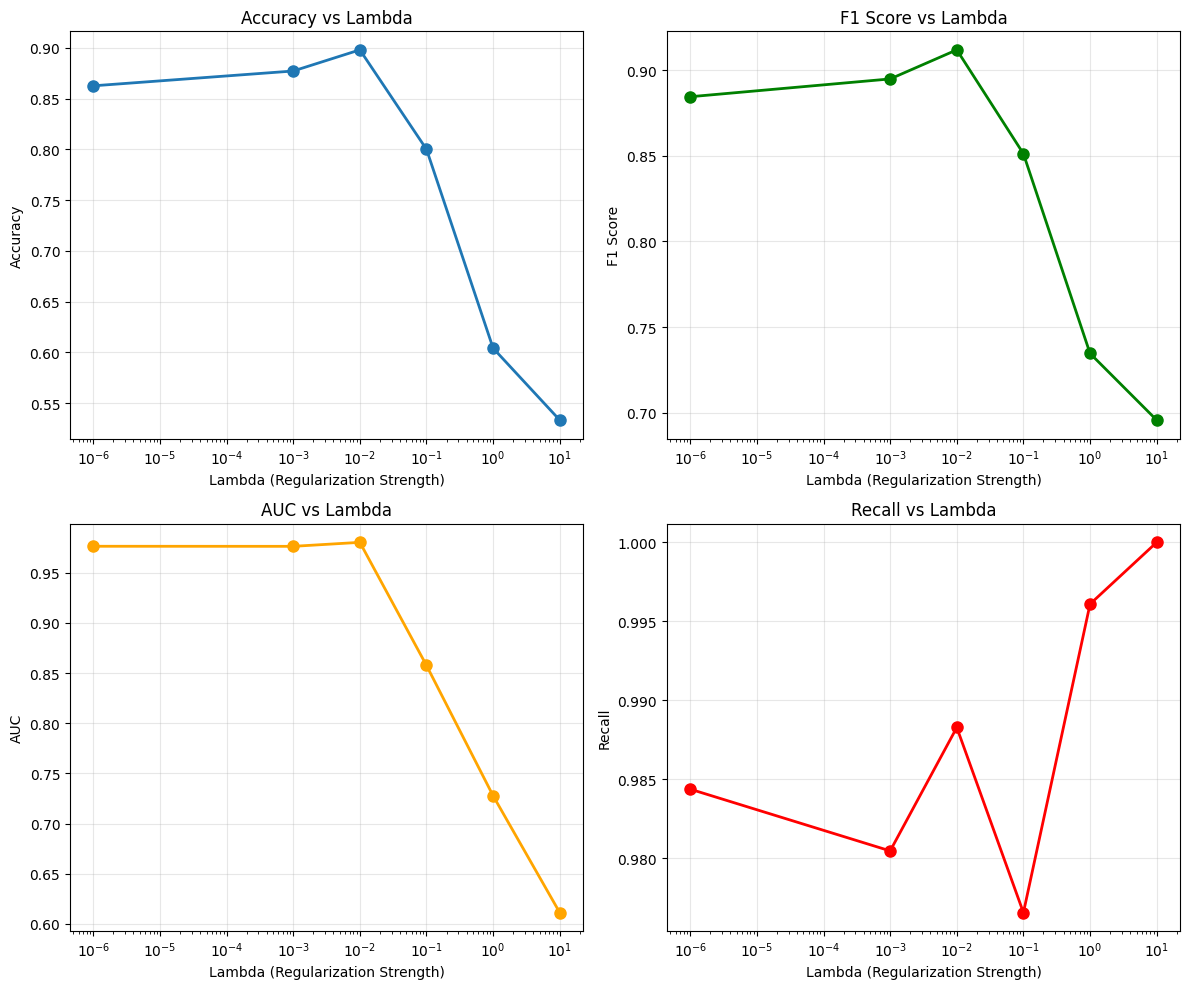

In [102]:
# Recall vs Regularization: Match LogPredict format with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Group by regularization and calculate mean metrics
reg_summary = results_df.groupby('regularization').agg({
    'test_acc': 'mean',
    'test_f1': 'mean',
    'test_auc': 'mean',
    'test_recall': 'mean'
}).reset_index()

# Sort by regularization strength order
reg_order = ['L2-0', 'L2-0.001', 'L2-0.01', 'L2-0.1', 'L2-1', 'L2-10']
reg_summary['regularization'] = pd.Categorical(reg_summary['regularization'], categories=reg_order, ordered=True)
reg_summary = reg_summary.sort_values('regularization')

# Create plot with LogPredict-style lambda handling
plot_df = reg_summary.copy()
plot_df['plot_lambda'] = plot_df['regularization'].apply(lambda x: 1e-6 if x == 'L2-0' else float(x.split('-')[1]))

axes[0, 0].plot(plot_df['plot_lambda'], plot_df['test_acc'], 'o-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Lambda (Regularization Strength)')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Accuracy vs Lambda')
axes[0, 0].set_xscale('log')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(plot_df['plot_lambda'], plot_df['test_f1'], 'o-', linewidth=2, markersize=8, color='green')
axes[0, 1].set_xlabel('Lambda (Regularization Strength)')
axes[0, 1].set_ylabel('F1 Score')
axes[0, 1].set_title('F1 Score vs Lambda')
axes[0, 1].set_xscale('log')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(plot_df['plot_lambda'], plot_df['test_auc'], 'o-', linewidth=2, markersize=8, color='orange')
axes[1, 0].set_xlabel('Lambda (Regularization Strength)')
axes[1, 0].set_ylabel('AUC')
axes[1, 0].set_title('AUC vs Lambda')
axes[1, 0].set_xscale('log')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(plot_df['plot_lambda'], plot_df['test_recall'], 'o-', linewidth=2, markersize=8, color='red')
axes[1, 1].set_xlabel('Lambda (Regularization Strength)')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].set_title('Recall vs Lambda')
axes[1, 1].set_xscale('log')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{RESULTS_PATH}/regularization_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

## Final Model with Best Hyperparameters


In [103]:
best_model_row = results_df.iloc[0]
best_model_name = f"{best_model_row['architecture']}_{best_model_row['regularization']}"

# Load best model and get test predictions
best_model = keras.models.load_model(f"{MODEL_PATH}/{best_model_name}.keras")
y_test_pred_prob = best_model.predict(X_test, verbose=0, batch_size=batch_size).flatten()
y_test_pred = (y_test_pred_prob > 0.5).astype(int)

# Calculate metrics
from sklearn.metrics import precision_score, recall_score, confusion_matrix as cm
test_acc = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
conf_matrix = cm(y_test, y_test_pred)

print("\n" + "=" * 80)
print("SUMMARY")
print("=" * 80)
print(f"\nBest model by Test AUC: {best_model_row['architecture']} + {best_model_row['regularization']}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"\nConfusion Matrix:")
print(conf_matrix)


SUMMARY

Best model by Test AUC: 5-Layer + L2-0.01
Test Accuracy: 0.8833
Test Precision: 0.8205
Test Recall: 1.0000
Test F1 Score: 0.9014

Confusion Matrix:
[[42 14]
 [ 0 64]]


In [106]:
# Model performance comparison table
print("\n" + "=" * 80)
print("DETAILED RESULTS: All 24 Models")
print("=" * 80)
print(results_df[['model_id', 'architecture', 'regularization', 'test_acc', 'test_auc', 'test_f1']].to_string(index=False))

print("\n" + "=" * 80)
print("PERFORMANCE BY ARCHITECTURE")
print("=" * 80)
arch_stats = results_df.groupby('architecture').agg({
    'test_acc': ['mean', 'std', 'min', 'max'],
    'test_auc': ['mean', 'std', 'min', 'max'],
    'test_f1': ['mean', 'std', 'min', 'max']
}).round(4)
print(arch_stats)

print("\n" + "=" * 80)
print("PERFORMANCE BY REGULARIZATION")
print("=" * 80)
reg_stats = results_df.groupby('regularization').agg({
    'test_acc': ['mean', 'std', 'min', 'max'],
    'test_auc': ['mean', 'std', 'min', 'max'],
    'test_f1': ['mean', 'std', 'min', 'max']
}).round(4)
print(reg_stats)


DETAILED RESULTS: All 24 Models
model_id architecture regularization  test_acc  test_auc  test_f1
      20      5-Layer        L2-0.01  0.883333  0.981864 0.901408
      01      2-Layer           L2-0  0.875000  0.981306 0.893617
      15      3-Layer       L2-0.001  0.883333  0.980748 0.901408
      02      2-Layer        L2-0.01  0.908333  0.980469 0.919708
      08      2-Layer        L2-0.01  0.900000  0.980469 0.913043
      14      3-Layer        L2-0.01  0.900000  0.978237 0.913043
      16      3-Layer         L2-0.1  0.875000  0.977679 0.892086
      05      2-Layer           L2-1  0.816667  0.977400 0.851351
      04      2-Layer         L2-0.1  0.891667  0.976283 0.905109
      10      2-Layer         L2-0.1  0.900000  0.976283 0.911765
      13      3-Layer           L2-0  0.858333  0.976004 0.881119
      09      2-Layer       L2-0.001  0.875000  0.975167 0.893617
      03      2-Layer       L2-0.001  0.866667  0.974888 0.885714
      07      2-Layer           L2-0  0.833